In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

from source_code.SqlCo import Sqldd

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled
Local Sec Env loaded


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## you can dl csv data with link and replace this code for pd.red_csv()
tip = Sqldd()
cnx, cursor = tip.get_bdd_co()
df = pd.read_sql(f"SELECT * FROM cov_baseline;", con=cnx) 

In [3]:
df.head(3)

,id,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,1,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
1,2,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
2,3,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,id,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
48794,50676,ZWE,Africa,Zimbabwe,2020-10-08,7919.0,4.0,11.571,229.0,0.0,...,1899.78,21.4,307.846,1.82,1.600,30.700,36.791,1.700,61.49,0.535
48795,50677,OWID_WRL,Null,World,2020-10-08,36194800.0,331910.0,306769.000,1053960.0,5679.0,...,15469.20,10.0,233.070,8.51,6.434,34.635,60.130,2.705,72.58,0.000
48796,50678,Null,Null,International,2020-10-08,696.0,0.0,0.000,7.0,0.0,...,0.00,0.0,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


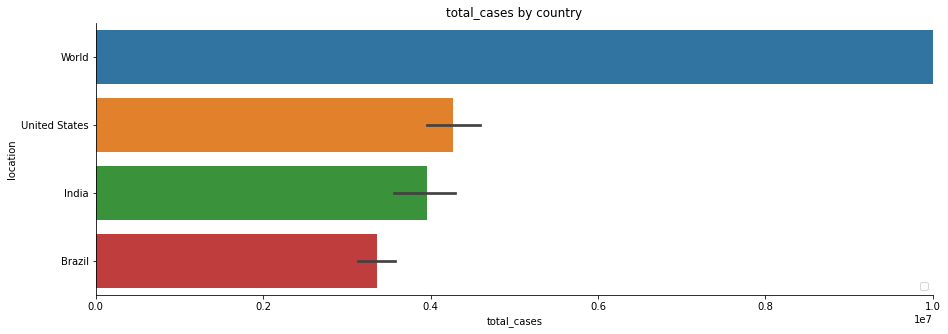

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

No handles with labels found to put in legend.


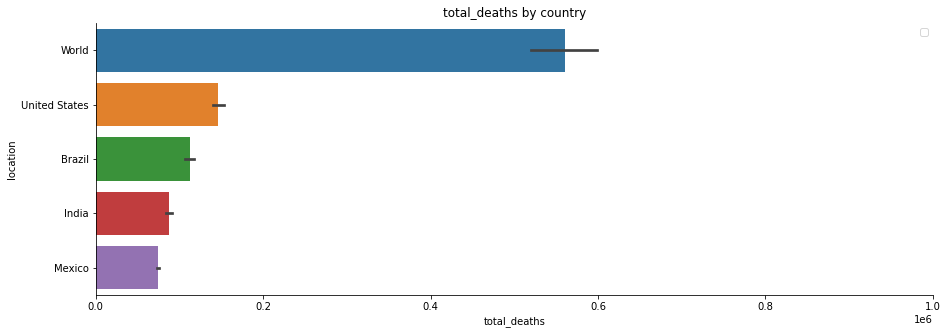

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


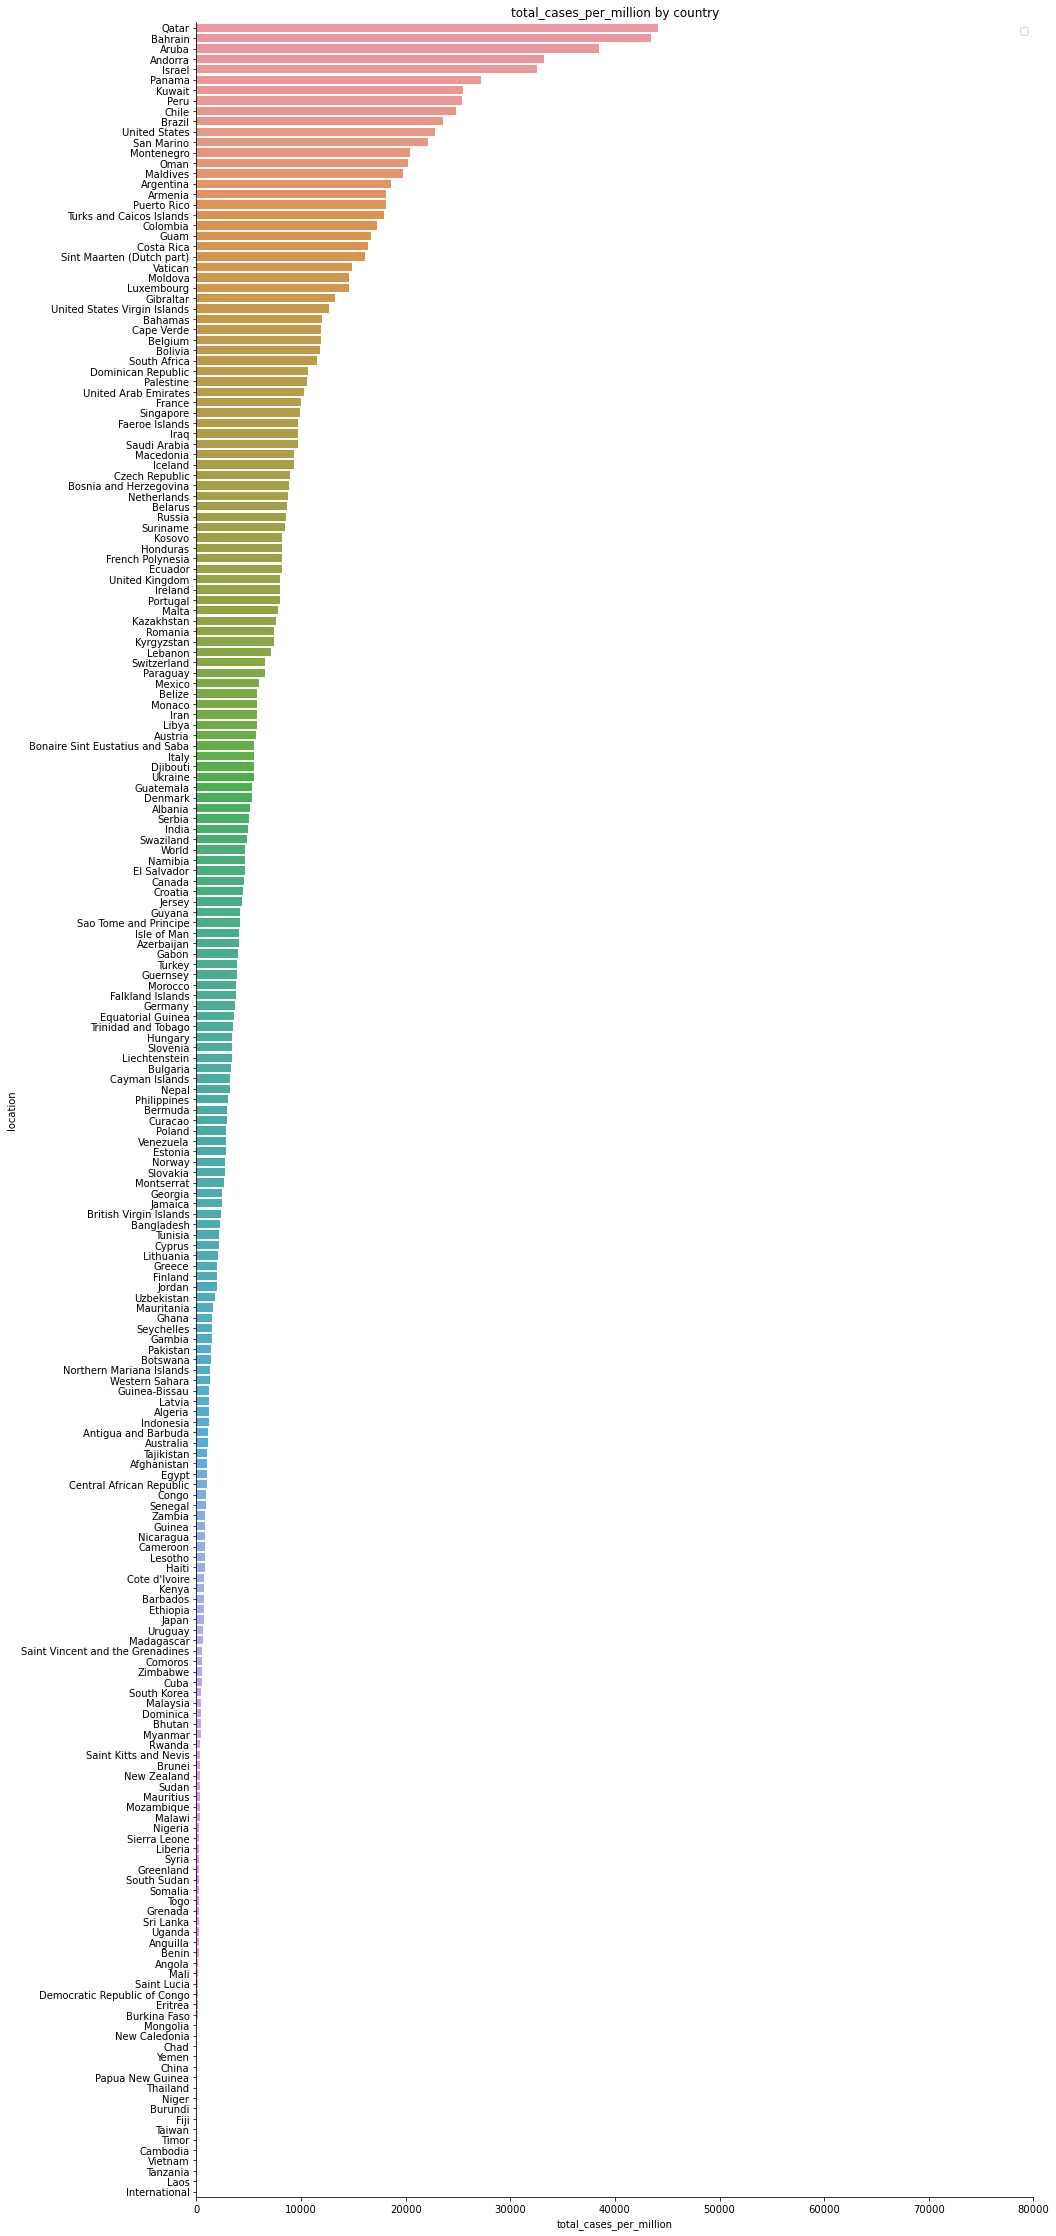

In [19]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=80000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


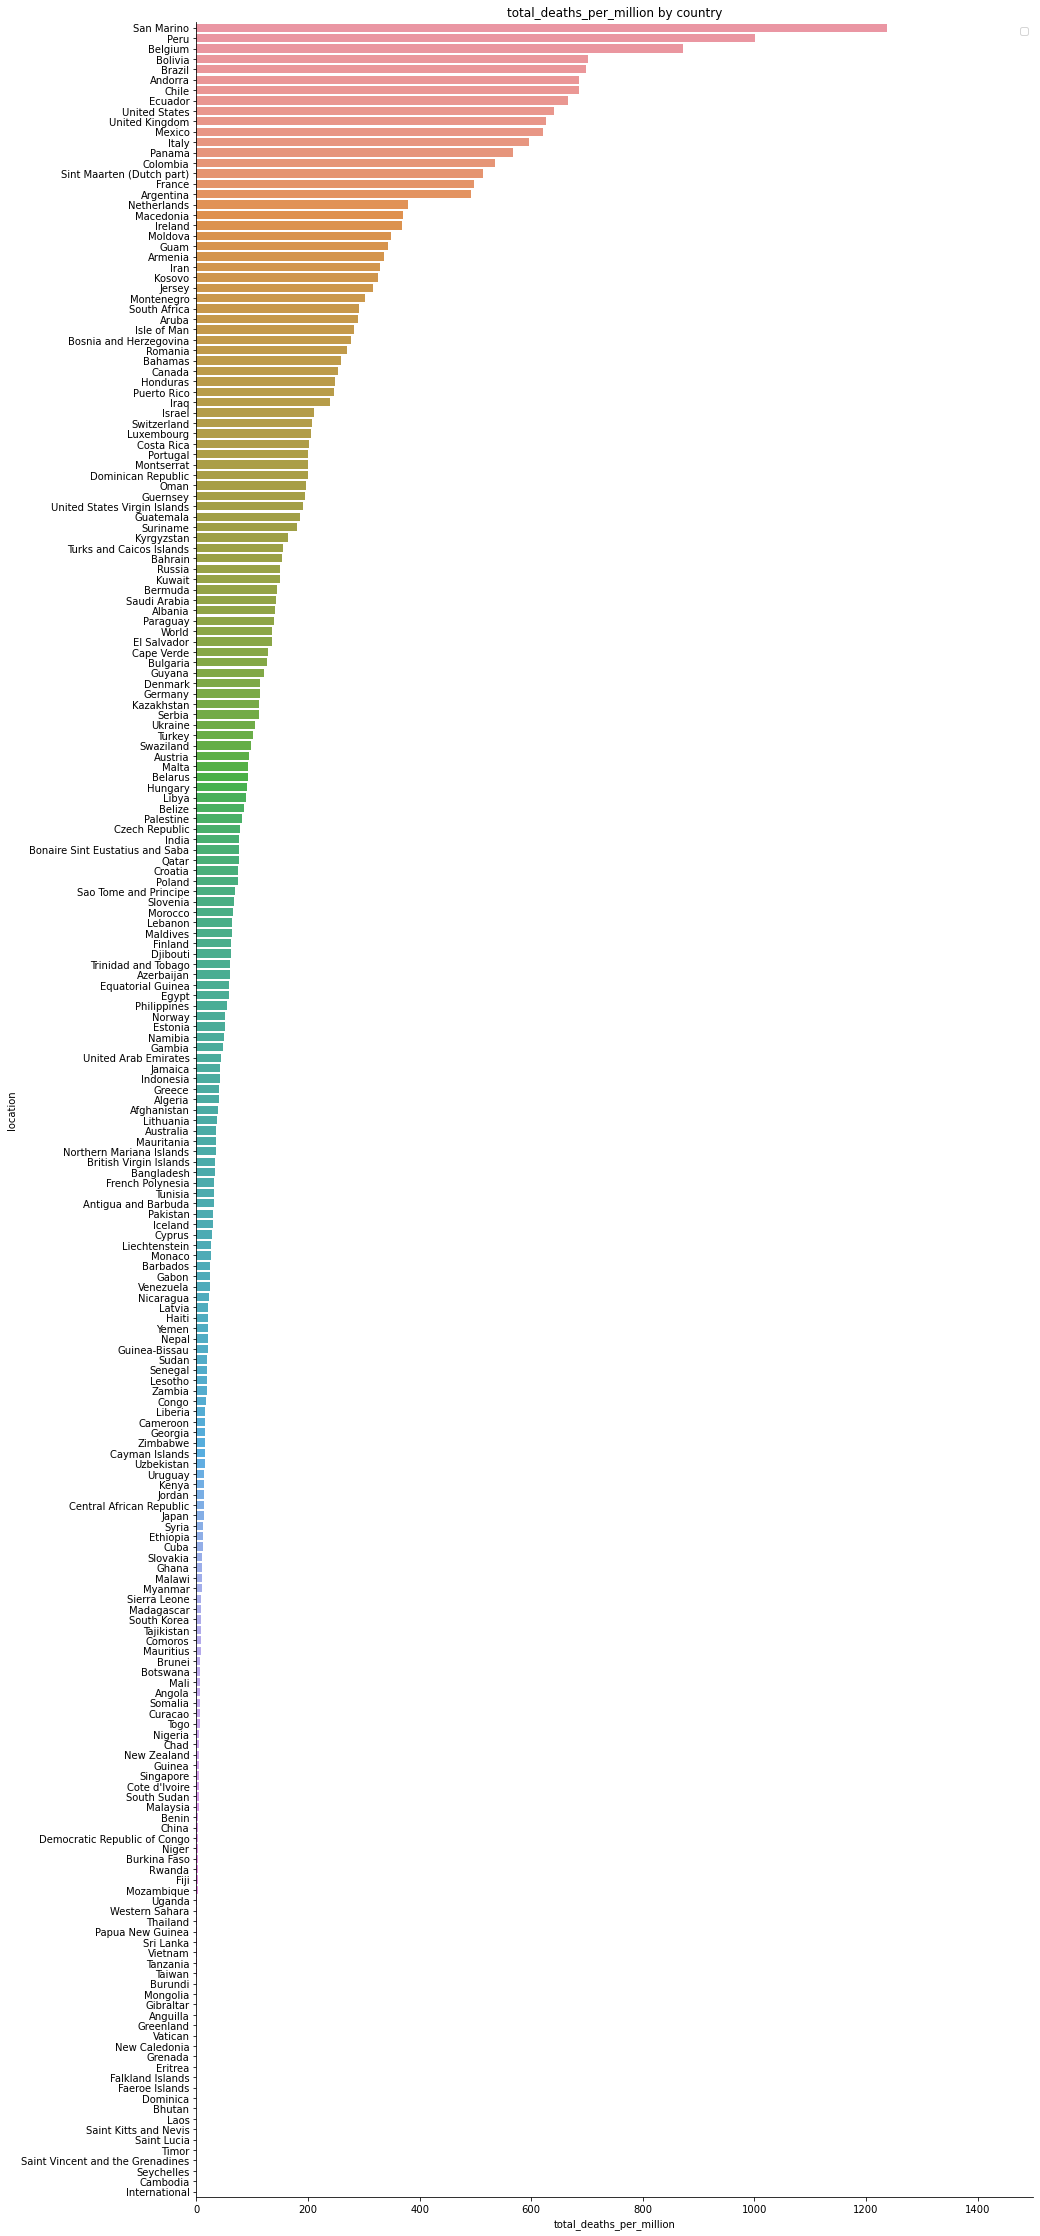

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

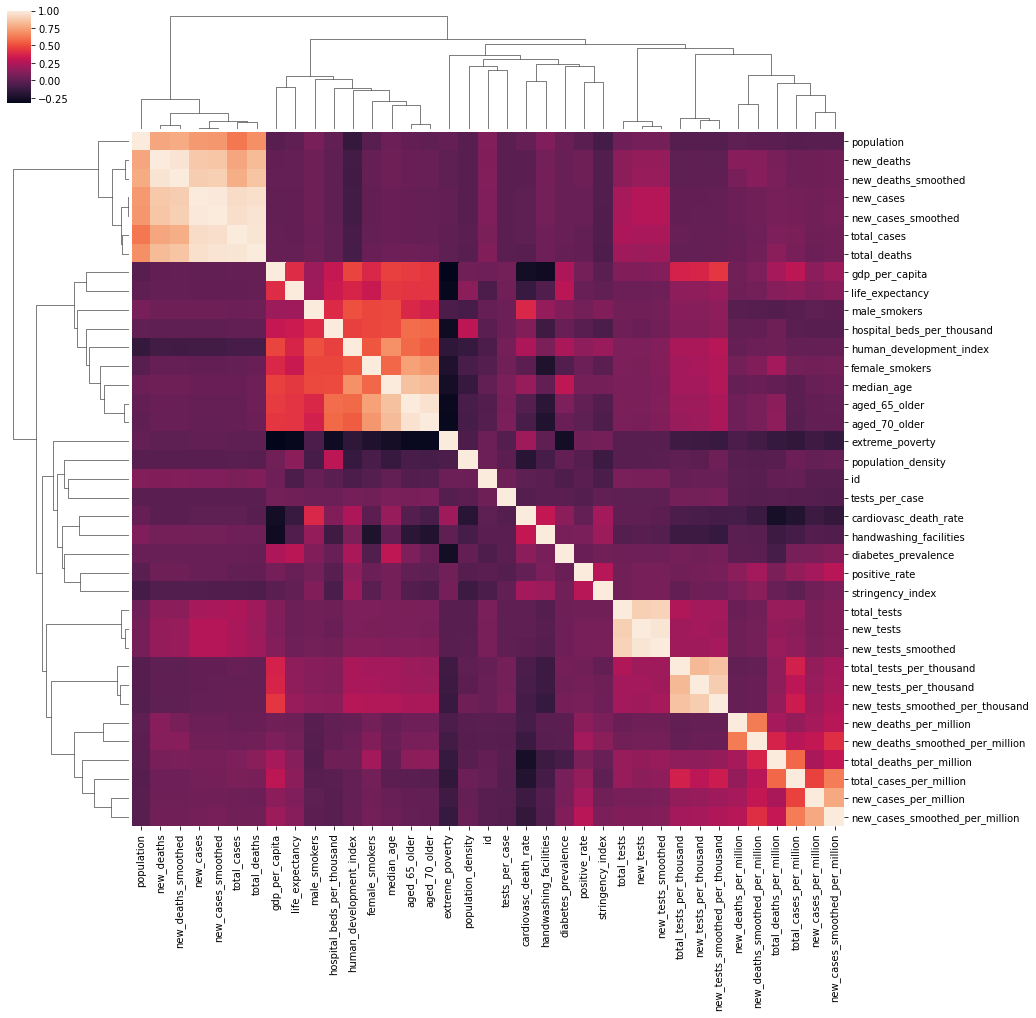

In [20]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [27]:
def createModel(df,subject,periode,country,n_splits=3,max_iter=5000):

    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [28]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [29]:
def conbine(df,subject,periode,country):
    vals, x_train, y_train, model = createModel(df,subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [30]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine(df,"total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine(df,"total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [31]:
periode = 3

In [32]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9968870056421997 (+/- 0.004283888639424898)
Coef :  [1.02846665e+00 7.38838226e-05 7.56600408e-05]
3 Last_days :  [[35523500 35848300 36194800]]
Today :  36194800
Prediction + :  463805
Tomorow :  36658605
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995213469436841 (+/- 0.00027262333026942514)
Coef :  [0.31366016 0.33856568 0.35742771]
3 Last_days :  [[1042400 1048180 1053960]]
Today :  1053960
Prediction + :  8383
Tomorow :  1062343
                                     


In [33]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7512654956184756 (+/- 0.34773985979890193)
Coef :  [-0.58862446  0.66820305  0.93066503]
3 Last_days :  [[624274 634763 653509]]
Today :  653509
Prediction + :  11081
Tomorow :  664590
                                     
--------- Total Death -----------------
                                     
R^2: 0.6141005998628676 (+/- 0.54008508094296)
Coef :  [-0.74089542  0.78627887  0.95357729]
3 Last_days :  [[32299 32365 32445]]
Today :  32445
Prediction + :  66
Tomorow :  32511
                                     


In [34]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9751924127556557 (+/- 0.031096981630085917)
Coef :  [-0.33323851 -0.00440221  1.33190664]
3 Last_days :  [[90652 90667 90689]]
Today :  90689
Prediction + :  19
Tomorow :  90708
                                     
--------- Total Death -----------------
                                     
R^2: -3.892411163319796 (+/- 6.803568258243239)
Coef :  [-0.07803334  0.0125139   1.05710377]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  4
Tomorow :  4743
                                     


In [35]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8819268525149675 (+/- 0.1656527057506964)
Coef :  [-0.80160293  0.88710601  0.91429144]
3 Last_days :  [[327586 330263 333940]]
Today :  333940
Prediction + :  2152
Tomorow :  336092
                                     
--------- Total Death -----------------
                                     
R^2: 0.2702482118851634 (+/- 1.0187643689647334)
Coef :  [-0.813651    0.89235568  0.92023324]
3 Last_days :  [[36002 36030 36061]]
Today :  36061
Prediction + :  39
Tomorow :  36100
                                     


In [36]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -3.533117531709175 (+/- 6.3985207043372485)
Coef :  [-0.19559212  0.17326477  1.03268903]
3 Last_days :  [[789932 789932 813412]]
Today :  813412
Prediction + :  8971
Tomorow :  822383
                                     
--------- Total Death -----------------
                                     
R^2: -0.8482198602546788 (+/- 2.3413287104099885)
Coef :  [-0.73159906  0.65173791  1.07892501]
3 Last_days :  [[32086 32086 32225]]
Today :  32225
Prediction + :  20
Tomorow :  32245
                                     


In [37]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8800816996243784 (+/- 0.16406230911568084)
Coef :  [0.23624707 0.38517416 0.39062007]
3 Last_days :  [[7458550 7501610 7549790]]
Today :  7549790
Prediction + :  72669
Tomorow :  7622459
                                     
--------- Total Death -----------------
                                     
R^2: 0.991270975781866 (+/- 0.011077595044515874)
Coef :  [-0.30382695  0.62624506  0.68028526]
3 Last_days :  [[210192 210909 211801]]
Today :  211801
Prediction + :  1043
Tomorow :  212844
                                     


In [38]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9065903280681394 (+/- 0.12980681719807258)
Coef :  [-0.81015214  0.84231532  0.97004339]
3 Last_days :  [[515571 530113 544275]]
Today :  544275
Prediction + :  12630
Tomorow :  556905
                                     
--------- Total Death -----------------
                                     
R^2: 0.7082775978284023 (+/- 0.3989114131254261)
Coef :  [-0.75739306  0.82771792  0.92886737]
3 Last_days :  [[42369 42445 42515]]
Today :  42515
Prediction + :  85
Tomorow :  42600
                                     


In [39]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9538223033652029 (+/- 0.06443386522639849)
Coef :  [-0.75972649  0.84028013  0.9199076 ]
3 Last_days :  [[303258 306086 310144]]
Today :  310144
Prediction + :  2274
Tomorow :  312418
                                     
--------- Total Death -----------------
                                     
R^2: 0.1417868821063211 (+/- 1.2080408307588824)
Coef :  [-0.77705493  0.83655546  0.93965884]
3 Last_days :  [[9546 9562 9578]]
Today :  9578
Prediction + :  17
Tomorow :  9595
                                     


In [40]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9971645705705989 (+/- 0.002781254411414242)
Coef :  [0.46391198 0.27627284 0.27230429]
3 Last_days :  [[475674 479825 483844]]
Today :  483844
Prediction + :  2859
Tomorow :  486703
                                     
--------- Total Death -----------------
                                     
R^2: 0.9081464306093944 (+/- 0.1287400115571195)
Coef :  [0.30602537 0.35961782 0.3466921 ]
3 Last_days :  [[27192 27419 27658]]
Today :  27658
Prediction + :  193
Tomorow :  27851
                                     


In [41]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9997861427588438 (+/- 0.00010007424879529558)
Coef :  [-0.51930128  0.74781842  0.76879208]
3 Last_days :  [[326046 327557 329138]]
Today :  329138
Prediction + :  1165
Tomorow :  330303
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995387728731865 (+/- 0.000322451944652525)
Coef :  [-0.80683313  0.89484304  0.91081019]
3 Last_days :  [[8498 8553 8609]]
Today :  8609
Prediction + :  46
Tomorow :  8655
                                     


In [42]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8453392159460216 (+/- 0.2113400300284302)
Coef :  [-0.08081057  0.50179942  0.58943504]
3 Last_days :  [[4927240 4969140 5000690]]
Today :  5000690
Prediction + :  52578
Tomorow :  5053268
                                     
--------- Total Death -----------------
                                     
R^2: 0.44429660583292385 (+/- 0.7784340734371245)
Coef :  [0.02581238 0.46347008 0.51972417]
3 Last_days :  [[146675 147494 148228]]
Today :  148228
Prediction + :  1352
Tomorow :  149580
                                     


In [43]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [44]:
model_data

[(36194800, 1053960, 36658605, 1062343),
 (653509, 32445, 664590, 32511),
 (333940, 36061, 336092, 36100),
 (813412, 32225, 822383, 32245),
 (7549790, 211801, 7622459, 212844),
 (90689, 4739, 90708, 4743),
 (544275, 42515, 556905, 42600),
 (310144, 9578, 312418, 9595),
 (483844, 27658, 486703, 27851),
 (329138, 8609, 330303, 8655),
 (5000690, 148228, 5053268, 149580)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [45]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()
    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    return pop_pred

In [46]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-10-08,France,664590.0,0.0,32511.0,0.0,0.0,0.0
0,2020-10-08,China,90708.0,0.0,4743.0,0.0,0.0,0.0
0,2020-10-08,Italy,336092.0,0.0,36100.0,0.0,0.0,0.0
0,2020-10-08,Spain,822383.0,0.0,32245.0,0.0,0.0,0.0
0,2020-10-08,United States,7622459.0,0.0,212844.0,0.0,0.0,0.0
0,2020-10-08,World,36658605.0,0.0,1062343.0,0.0,0.0,0.0
0,2020-10-08,United Kingdom,556905.0,0.0,42600.0,0.0,0.0,0.0
0,2020-10-08,Germany,312418.0,0.0,9595.0,0.0,0.0,0.0
0,2020-10-08,Iran,486703.0,0.0,27851.0,0.0,0.0,0.0
0,2020-10-08,Turkey,330303.0,0.0,8655.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"data\\Pred\\predDf{date.today()}.csv")

In [40]:
pre_pred_tobdd = predpred.drop(columns=['total_cases_real','total_deaths_real','error_abs_cases','error_abs_deaths'])
pre_pred_tobdd

,date,country,total_cases_predict,total_deaths_predict
0,2020-10-07,France,642397.0,32434.0
0,2020-10-07,China,90687.0,4743.0
0,2020-10-07,Italy,332143.0,36060.0
0,2020-10-07,Spain,838909.0,32619.0
0,2020-10-07,United States,7577800.0,211905.0
0,2020-10-07,World,36409590.0,1057131.0
0,2020-10-07,United Kingdom,540873.0,42486.0
0,2020-10-07,Germany,308285.0,9576.0
0,2020-10-07,Iran,482634.0,27614.0
0,2020-10-07,Turkey,328788.0,8601.0


In [1]:
# try:
#     data_job = data_up_pip(pre_pred_tobdd) 
#     data_job.up_pred()
#     data_job.clean_leave()
# except:
#     print("BDD job Failed -- Normal if you not have acces to main code")